<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
matplotlib 3.7.1
numpy 1.25.2
pandas 2.0.3
sklearn 1.2.2
torch 2.2.1+cu121
cuda:0


In [2]:
# 在colab上挂载硬盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/cifar10

sampleSubmission.csv  test.7z  train.7z  trainLabels.csv


In [4]:
# copy到本地，数据在云盘上也不好操作  .就是当前目录下（/content）
!cp /content/drive/MyDrive/cifar10/train.7z .
!cp /content/drive/MyDrive/cifar10/test.7z .
!cp /content/drive/MyDrive/cifar10/trainLabels.csv .
!cp /content/drive/MyDrive/cifar10/sampleSubmission.csv .

In [5]:
%pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.7 MB/s eta 0:00:00


In [6]:
# 解压训练集
import py7zr
a = py7zr.SevenZipFile(r'train.7z','r')
a.extractall(path=r'./')
a.close()

In [7]:
# 解压测试集
a = py7zr.SevenZipFile(r'test.7z','r')
a.extractall(path=r'./')
a.close()

In [8]:
from pathlib import Path

DATA_DIR = Path("./")

train_name_label = DATA_DIR / "trainLabels.csv"
test_name_label = DATA_DIR / "sampleSubmission.csv" #测试集图像，标签 提交模板
train_img_folder = DATA_DIR / "train"
test_img_folder = DATA_DIR / "test"

#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

def parse_csv_file(filepath, folder): #filepath:csv文件路径，folder:图片所在文件夹
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
        #第一行不需要，因为第一行是标题
        lines = f.readlines()[1:]
    for line in lines:
        image_name, label_str = line.strip('\n').split(',')
        image_full_path = folder / f"{image_name}.png"
        results.append((image_full_path, label_str)) #得到对应图片的路径和分类
    return results # [(路径,label),(路径,label),(路径,label),...]

#解析对应的文件夹
train_labels_info = parse_csv_file(train_name_label, train_img_folder)
test_labels_info = parse_csv_file(test_name_label, test_img_folder)
#打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_labels_info[0:5])
print(len(train_labels_info), len(test_labels_info))

[(PosixPath('train/1.png'), 'frog'),
 (PosixPath('train/2.png'), 'truck'),
 (PosixPath('train/3.png'), 'truck'),
 (PosixPath('train/4.png'), 'deer'),
 (PosixPath('train/5.png'), 'automobile')]
[(PosixPath('test/1.png'), 'cat'),
 (PosixPath('test/2.png'), 'cat'),
 (PosixPath('test/3.png'), 'cat'),
 (PosixPath('test/4.png'), 'cat'),
 (PosixPath('test/5.png'), 'cat')]
50000 300000


In [9]:
train_df = pd.DataFrame(train_labels_info[0:45000]) # 取前45000张图片作为训练集
train_df.columns = ['imgpath', 'label']

valid_df = pd.DataFrame(train_labels_info[45000:]) # 取后5000张图片作为验证集
valid_df.columns = ['imgpath', 'label']

test_df = pd.DataFrame(test_labels_info)
test_df.columns = ['imgpath', 'label']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

       imgpath       label
0  train/1.png        frog
1  train/2.png       truck
2  train/3.png       truck
3  train/4.png        deer
4  train/5.png  automobile
           imgpath       label
0  train/45001.png       horse
1  train/45002.png  automobile
2  train/45003.png        deer
3  train/45004.png  automobile
4  train/45005.png    airplane
      imgpath label
0  test/1.png   cat
1  test/2.png   cat
2  test/3.png   cat
3  test/4.png   cat
4  test/5.png   cat


In [10]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Cifar10Dataset(Dataset):
    df_map = {
        "train": train_df,
        "eval": valid_df,
        "test": test_df
    }
    label_to_idx = {label: idx for idx, label in enumerate(class_names)} # 用于label转idx
    idx_to_label = {idx: label for idx, label in enumerate(class_names)} # 用于idx转label
    def __init__(self, mode, transform=None):
        self.df = self.df_map.get(mode, None) # 获取对应的df
        if self.df is None:
            raise ValueError("mode should be one of train, val, test, but got {}".format(mode))
        # assert self.df, "df is None"
        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.df.iloc[index] # 获取图片路径和标签
        img = Image.open(img_path).convert('RGB') # 图像都是有一定压缩的，转为rgb三通道无压缩图像   img:[height,width,channel]
        # # img 转换为 channel first
        # img = img.transpose((2, 0, 1))
        # transform
        img = self.transform(img)
        # label 转换为 idx
        label = self.label_to_idx[label]
        return img, label

    def __len__(self):
        return self.df.shape[0] # 返回df的行数,样本数

IMAGE_SIZE = 32
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

transforms_train = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), #缩放
        # 图像增强（这是随机的，说明从ds中取同一位置的图片多次，每次取到的都是随机增强后的，每次取到的都不太一样）这样的话，每个epoch,train_loader迭代出来的图像都不太一样。通过这样训练，可以提高模型的泛化能力：图像经过一定的旋转，模型仍能识别
        transforms.RandomRotation(40), #随机旋转；这个函数的作用是将输入图像随机旋转一个角度，这个角度的范围是从 -40 度到 40 度（不包括 -40 度和 40 度）。旋转是围绕图像中心进行的，除非指定了不同的中心点。
        transforms.RandomHorizontalFlip(),  #随机水平翻转；这个函数会随机地水平翻转（即沿垂直轴翻转）输入图像，概率为 50%。

        transforms.ToTensor(), #转换为tensor
        transforms.Normalize(mean, std) #标准化
    ]) #数据增强

transforms_eval = transforms.Compose([
        # resize
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

train_ds = Cifar10Dataset("train", transforms_train) # [(),(),(),...]
eval_ds = Cifar10Dataset("eval", transforms_eval)

In [11]:
print(train_ds.idx_to_label) # 调用对象属性
train_ds.label_to_idx

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [12]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
eval_loader= DataLoader(eval_ds, batch_size=batch_size, shuffle=False)

In [13]:
# 计算每个通道的均值和方差
# def cal_mean_std(ds):
#     mean = 0.
#     std = 0.
#     for img, _ in ds:
#         mean += img.mean(dim=(1, 2))
#         std += img.std(dim=(1, 2))
#     mean /= len(ds)
#     std /= len(ds)
#     return mean, std

# 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

## 定义模型

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),# 批标准化
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), # stride不指定，默认等于kernel_size
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        ) #Sequential:从上到下，顺序执行的一个容器；使得forward函数简化

    def forward(self, x):
        return self.model(x)

for key, value in CNN(len(class_names)).named_parameters():  # 模型参数
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

             model.0.weight             paramerters num: 3456
              model.0.bias              paramerters num: 128
             model.2.weight             paramerters num: 128
              model.2.bias              paramerters num: 128
             model.3.weight             paramerters num: 147456
              model.3.bias              paramerters num: 128
             model.5.weight             paramerters num: 128
              model.5.bias              paramerters num: 128
             model.7.weight             paramerters num: 294912
              model.7.bias              paramerters num: 256
             model.9.weight             paramerters num: 256
              model.9.bias              paramerters num: 256
            model.10.weight             paramerters num: 589824
             model.10.bias              paramerters num: 256
            model.12.weight             paramerters num: 256
             model.12.bias              paramerters num: 256
            mo

In [15]:
# 模型总参数
total_params = sum(p.numel() for p in CNN(len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8779914


## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [16]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [17]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [18]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_best_only=True):
        self.save_dir = save_dir
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [19]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [20]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1) #最大值的索引

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())     # 计算准确率
                loss = loss.cpu().item() # 计算损失
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step # 记录每一步的损失和准确率
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 20

model = CNN(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/cifar-10")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/cifar-10", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model,
    train_loader,
    eval_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/14080 [00:00<?, ?it/s]

Early stop at epoch 17 / global_step 11968


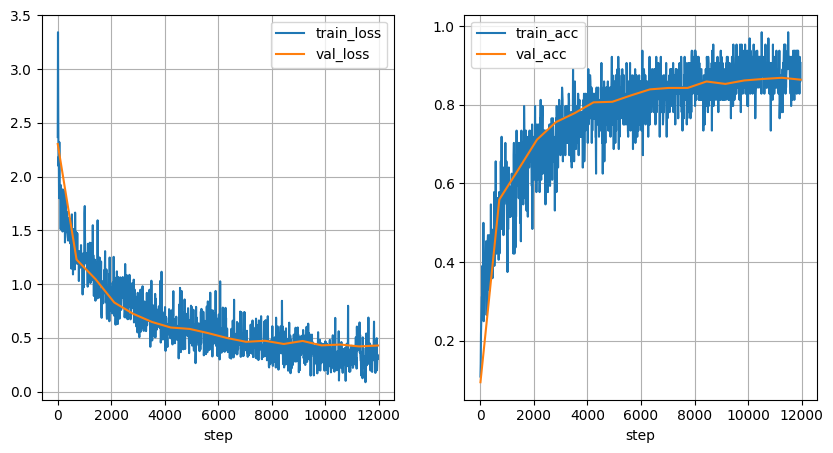

In [21]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [22]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/cifar-10/best.ckpt", map_location="cpu"))

model.eval()
loss, acc = evaluating(model, eval_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4207
accuracy: 0.8686


# 推理

In [23]:
# test_df
test_ds = Cifar10Dataset("test", transform=transforms_eval)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

preds_collect = []
model.eval()
for data, fake_label in tqdm(test_loader):
    data = data.to(device=device)
    logits = model(data)
    preds = [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()]
    preds_collect.extend(preds)

test_df["class"] = preds_collect
test_df.head()

  0%|          | 0/4688 [00:00<?, ?it/s]

,imgpath,label,class
0,test/1.png,cat,airplane
1,test/2.png,cat,airplane
2,test/3.png,cat,automobile
3,test/4.png,cat,ship
4,test/5.png,cat,bird


In [24]:
# 导出 submission.csv
test_df.to_csv("submission.csv", index=False)

In [25]:
!tar cvzf runs.tar.gz runs
!tar cvzf colab06.tar.gz checkpoints

runs/
runs/cifar-10/
runs/cifar-10/training_accuracy_accuracy/
runs/cifar-10/training_accuracy_accuracy/events.out.tfevents.1715826264.ac7a052db194.204.3
runs/cifar-10/training_loss_loss/
runs/cifar-10/training_loss_loss/events.out.tfevents.1715826264.ac7a052db194.204.1
runs/cifar-10/training_loss_val_loss/
runs/cifar-10/training_loss_val_loss/events.out.tfevents.1715826264.ac7a052db194.204.2
runs/cifar-10/training_accuracy_val_accuracy/
runs/cifar-10/training_accuracy_val_accuracy/events.out.tfevents.1715826264.ac7a052db194.204.4
runs/cifar-10/events.out.tfevents.1715826256.ac7a052db194.204.0
runs/cifar-10/training_learning_rate_learning_rate/
runs/cifar-10/training_learning_rate_learning_rate/events.out.tfevents.1715826264.ac7a052db194.204.5
checkpoints/
checkpoints/cifar-10/
checkpoints/cifar-10/best.ckpt


[test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()]

step1:  logits.argmax(axis=-1).cpu().tolist() 把 最大值的标签(预测类别) 放到列表中
step2:  [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()]

In [4]:
import pandas as pd
sub = pd.read_csv('./submission.csv')
sub.head()

,id,label1,label
0,test/1.png,cat,airplane
1,test/2.png,cat,airplane
2,test/3.png,cat,automobile
3,test/4.png,cat,ship
4,test/5.png,cat,bird


In [5]:
sub.drop('label1', axis=1, inplace=True)
sub['id'] = pd.Series(range(1, 300000 + 1))
sub.head()

,id,label
0,1,airplane
1,2,airplane
2,3,automobile
3,4,ship
4,5,bird


In [6]:
# 导出 submission.csv
sub.to_csv("submission(end).csv", index=False)